# "Statistical Inference on Iris data"
> "Understand how to use univariate and multivariate normal distribution in inference"

- toc: false
- branch: master
- badges: true
- comments: true
- author: Saibaba Telukunta
- categories: [iris, multivariate, univariate, normal_distribution]

Introduction
---

This article assumes that reader is familiar with coding, basic probability theory including normal distributions (univariate, multivariate or MVN), and usage of python libraries like numpy, tensorflow.

Say, we are given a data point $x$ which is a d-dimensional feature vector. We are asked to classify, which category could it fit in one of the given $c$ categories. Let $w_i$ represent the $i^{th}$ categor. Let $W$ be a random variable representing the category.

If we do not care about the content/features of $x$, we can just see which category occurs most abundantly and assign that class as the category for the data point. Let's call this blind assignment. More precisely, we check which of all probabilities, $P(W=w_i)$ is the highest, and assign $x$ to it without much thinking. But we know that is not the right answer as we end up assigning all data points to the most popular one (or randomly if all occur equally abundantly). It becomes more troublesome particularly when mis-assignment could lead to risks or penalties. So, what can we do?

We could dive deep into $x$ and check which of the categories are better representative of the features present in $x$. Of these, pick the one that best represents these features. Hence, by looking at the evidence $x$, we adjust our decision of which class to use (bayes theorem).

$P(W=w_i|X=x) = \frac{P(X=x|W=w_i) * P(W=w_i)}{\sum_i P(X=x|W=w_i) * P(W=w_i)}$

Ignoring the denominator as it is the same for all categories, we are now looking at $P(X=x|W=w_i) * P(W=w_i)$ to make decision.

But, where do we get $P(W=w_i)$ and $P(X=x|W=w_i)$ from? Well, $P(W=w_i)$ is needed anyway even for blind assignment case.

So, how do we determine these probabilities? There are two key questions that need to be answered:
* Shape / PDF
* Parameters of the PDF once we decided a PDF. 

**How do we determine PDF?**

Let's say PDF has been determined using some domain/background knowledge, or making some assumptions by looking at descriptive statistics, or conducting some tests.

**How do we estimate the parameters ?**

We could gather some representative data D and use any of estimation techniques.

For example, we can use the maximum likelihood estimate or MLE of the chosen PDF to compute $P(W=w_i)$. That is not a problem except in cases where we might not have correct proportion of them that reflect true population. Let's ignore it for now and assume that sample reflects correct proportion of categories.

The bigger problem is computing $P(X|W=w_i)$ using the same D. Why? In D, for a given $W=w_i$, there are in general very few entries that correspond to each possible combination of features. If $x$ has lot of features, to cover for each feature combination in $x$, we need large (exponential) number of examples to get a useful representation of them for estimating the conditional probabilities.

As a side note, there are other issues in applying MLE to find $P(X|W=w_i)$:
* Consider the case where a particular feature vector with specific values for each dimension did not occur in the data at all. We cannot use 0 as the probability, but a low prior probability. So, instead of MLE we should use bayes posterior.
* There is another problem with MLE: it does not treat that observing 6 heads out 10 coin flips different from 60 out of 100. MLE estimate is still 0.6. But we know with 100, we are more confident. So, instead of MLE we should again use bayes posterior.
* MLE relies too much on the D, so biased towards it.

In summary, here are the key limitations in learning from data: If we can leverage more dimensions to make decision, we could be performing better. But, that also means we need more data so that it covers the various permutations of the features values. This also means we need more computing power. So, we have to make a trade off here between the number of features vs. available data vs. computing power we have.

In any case, once we determine the posterior probabilities for each catagory using the sample dataset D, we can then plug in feature values in $x$ to find the category that has highest posterior probability and we assign that category to $x$. There are other ways to, but I am keeping it simple for now.

An example
---

Let's demonstrate above concepts through an example using the well known Iris dataset.

In [ ]:
!pip install pingouin

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfd = tfp.distributions

from sklearn import datasets
from sklearn.model_selection import train_test_split

from scipy.interpolate import UnivariateSpline
from scipy.stats.kde import gaussian_kde

from pingouin import multivariate_normality

import operator
import math as m

In [3]:
pi = tf.constant(m.pi)

plt.rcParams["axes.grid"] = False

setosa = 0
versicolor = 1
virginica = 2

labels = ['setosa', 'versicolor', 'virginica']
sepal_length = 0
sepal_width = 1
petal_length = 2
petal_width = 3

marker_setosa = 's'
color_setosa = 'b'
marker_versicolor = 'o'
color_versicolor = 'r'
marker_virginica = 'v'
color_virginica = 'g'    


In [4]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

So, there are 4 features (dimensions): sepal length, sepal width, petal length, petal width.
And there are 3 categories or classes: setosa, versicolor, virginica.

And there are equal distribution of data across all classes (50 each). So $P(W=w_i) = \frac{1}{3}$ and hence effectively can be ignored in the posterior probability calculation. We also ignore the denominator as it is the same for all categories.

So, if we need to categerozie an unlabelled flower,  with blind assignment, we do not have a clear winner, but randomly assign to one of the classes. We know it won't perform well as we could be wrong 2 out of 3 times on average in the long run.

Since petal length and width have high correlation with the class, lets see if we can use use these features of the unlabelled flower and make a better determination of the category to which it belongs.

Let's also do a couple of things (1) shuffle and pick 100 records out of 150. We use them for estmating parameters and validation (2) We use the remaining 50 to assess performance on new data.

In [5]:
data, target = iris.data, iris.target

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

X = x_train[:, 2:]  # we only take the last two features, petal_length, petal_width
y = y_train

X_test = x_test[:, 2:]

setosa_indexes = np.array(y==setosa)
X_train_setosa = X[setosa_indexes]
y_tranin_setosa = y[setosa_indexes]

versicolor_indexes = np.array(y==versicolor)
X_train_versicolor = X[versicolor_indexes]
y_train_versicolor = y[versicolor_indexes]

virginica_indexes = np.array(y==virginica)
X_train_virginica = X[virginica_indexes]
y_train_virginica = y[virginica_indexes]

test_setosa_indexes = np.array(y_test==setosa)
X_test_setosa = X_test[test_setosa_indexes]
test_versicolor_indexes = np.array(y_test==versicolor)
X_test_versicolor = X_test[test_versicolor_indexes]
test_virginica_indexes = np.array(y_test==virginica)
X_test_virginica = X_test[test_virginica_indexes]

First, let's visually see how the distribution of data looks like across categories using petal length as feature to check.

In [6]:
# plot data as probability (value vs. count)
def plot_prob(data, l):
    # this create the kernel, given an array it will estimate the probability over that values
    kde = gaussian_kde( data )
    # these are the values over wich your kernel will be evaluated
    dist_space = linspace( min(data), max(data), 100 )
    # plot the results
    plt.plot( dist_space, kde(dist_space), label=l )
    plt.xlabel('petal length')
    plt.ylabel('count')

No handles with labels found to put in legend.


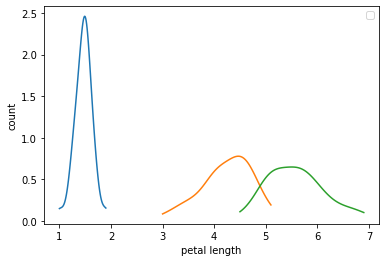

In [7]:
# distribution of petal length in each class
plt.legend(loc='upper right')

plot_prob(X_train_setosa[:, 0], 'setosa')
plot_prob(X_train_versicolor[:, 0], 'versicolor')
plot_prob(X_train_virginica[:, 0], 'virginica')
plt.show()

Looks like there is some discriminating power to petal length. Also, notice that not ideal, but with in each category, the records are distributed symmetrically around mean and probability decreasing as moving away from the mean. So, let's use normal distribution as the PDF. There is a troublesome interval [4.5, 5] of the petal length where we could not positively conclude if the record belongs to versicolor or virginica. But, let's try anyway and see where it takes us.

We need to estimate the mean and variance from the the sample of 100 records.

In [8]:
class NormalCategory:
    def __init__(self, data, ndim):
        self.ndim = ndim
        if ndim == 1:
            self.data = data
            self.mean, self.var =  np.mean(data), np.var(data)
            self.gauss = tfd.Normal(self.mean, np.sqrt(self.var))
        elif ndim == 2:

            # For MVNm we need mean vector and covariance matrix.
            self.data = tf.constant( [ [a, b] for (a, b) in zip(data[:, 0], data[:, 1]) ])    
            self.m, self.v = tf.nn.moments(self.data, axes=[0])
            # self.cov = tfp.stats.covariance(self.data, sample_axis=0, event_axis=1, keepdims=False)
            # hand calculate covariance just to shed more light on how it is done
            self.__cov__()
            self.gauss = tfd.MultivariateNormalFullCovariance(loc=self.m, covariance_matrix=self.cov)
            # self.gauss =  MultivariateNormalTriL(loc=self.m, scale_tril=tf.linalg.cholesky(self.cov))

    # Not a true posterior, but a stand-in for it since we are igning the common denominator
    def posterior(self, x):
        return self.gauss.prob(x).numpy()

    def __cov__(self):
        demeaned = self.data - self.m
        n = self.data.shape[0]
        demeanedT = tf.transpose(demeaned)
        self.cov = tf.tensordot(demeanedT, demeaned, axes=1)/(n)

In [9]:
class InferenceEngine:
    def __init__(self):
        self.correct = 0
        self.wrong = 0
        self.categories = []
        self.labels = []

    def add_category(self, cat, label):
        self.categories.append(cat)
        self.labels.append(label)

    def predict(self, a):
        my_list = [cat.posterior(a) for cat in self.categories]
        ndx, m = max(enumerate(my_list), key=operator.itemgetter(1))
        return (ndx, self.labels[ndx])

In [10]:
class IrisVerifier:

    def __init__(self, engine, ndim):
        self.correct = 0
        self.wrong = 0
        self.ndim = ndim
        self.engine = engine


    def __validate__(self, data, expected_index, unexpected_index_1, unexpected_index_2):

        result_expected = []
        result_unexpected_1 = []
        result_unexpected_2 = []
        for xy in zip(data[:, 0], data[:, 1]):
            a, b = xy[0], xy[1]
            if self.ndim == 1:
                p, lbl  = engine.predict(a)
            elif self.ndim == 2:
                p, lbl  = engine.predict([a, b])

            if (p == expected_index):
                result_expected.append((a,b))
                self.correct += 1
            if (p == unexpected_index_1):
                result_unexpected_1.append((a, b))
                self.wrong += 1
            if (p == unexpected_index_2):
                result_unexpected_2.append((a, b))
                self.wrong += 1 
        
        return (result_expected, result_unexpected_1, result_unexpected_2)

    def verify(self, setosa_data, versicolor_data, virginica_data):
        validate_setosa_setosa,  validate_setosa_versicolor, validate_setosa_virginica = self.__validate__(setosa_data, 0, 1, 2)
        print("setosa marked as versicolor: ", validate_setosa_versicolor)
        print("setosa marked as virginica: ", validate_setosa_virginica)

        validate_versicolor_versicolor, validate_versicolor_setosa, validate_versicolor_virginica= self.__validate__(versicolor_data, 1, 0, 2)   
        print("versicolor marked as setosa: ", validate_versicolor_setosa)
        print("versicolor marked as virginica: ", validate_versicolor_virginica)

        validate_virgenica_virgenica, validate_virgenica_setosa, validate_virginica_versicolor = self.__validate__(virginica_data, 2, 0, 1)    
        print("virginica marked as setosa: ", validate_virgenica_setosa)
        print("virginica marked as versicolor: ", validate_virginica_versicolor)

Let's use that and see what kind of performance we get.

In [11]:
cat_setosa  = NormalCategory(X_train_setosa[:, 0], 1)
cat_versicolor = NormalCategory(X_train_versicolor[:, 0], 1)
cat_virginica = NormalCategory(X_train_virginica[:, 0], 1)

engine = InferenceEngine()

engine.add_category(cat_setosa, "setosa")
engine.add_category(cat_versicolor, "versicolor")
engine.add_category(cat_virginica, "virginica")

verifier = IrisVerifier(engine, 1)

print("Verify train data...")
verifier.verify(X_train_setosa, X_train_versicolor, X_train_virginica)

print("")

print("Verify test data...")
verifier.verify(X_test_setosa, X_test_versicolor, X_test_virginica)

print("Total correct = " , verifier.correct)
print("Total wrong = ", verifier.wrong)
print("% correct: ", round(verifier.correct*100/150, 2))

Verify train data...
setosa marked as versicolor:  []
setosa marked as virginica:  []
versicolor marked as setosa:  []
versicolor marked as virginica:  [(5.0, 1.7), (4.9, 1.5), (5.1, 1.6)]
virginica marked as setosa:  []
virginica marked as versicolor:  [(4.5, 1.7), (4.8, 1.8)]

Verify test data...
setosa marked as versicolor:  []
setosa marked as virginica:  []
versicolor marked as setosa:  []
versicolor marked as virginica:  [(4.9, 1.5)]
virginica marked as setosa:  []
virginica marked as versicolor:  [(4.8, 1.8)]
Total correct =  143
Total wrong =  7
% correct:  95.33


Not bad at all, we got more than 95% success. Let's see if we can improve by considering one more feature: petal width.

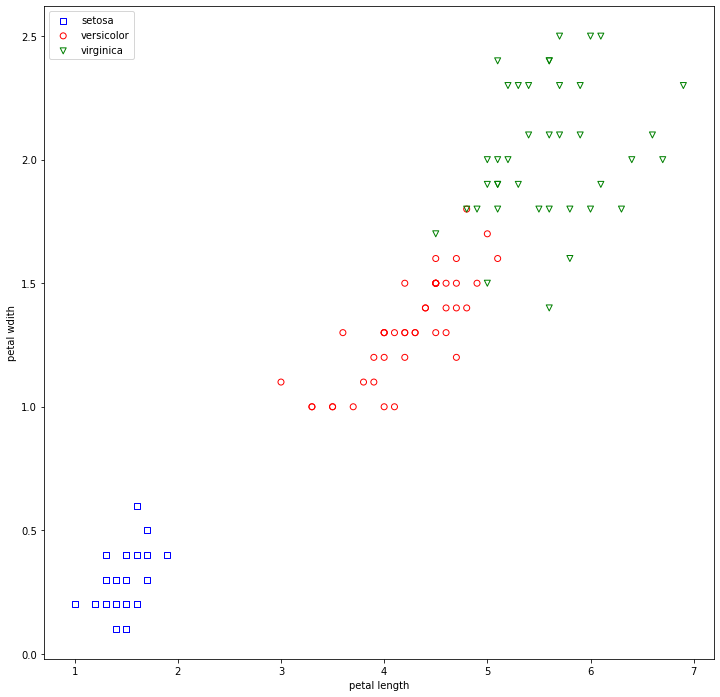

In [12]:
def plot_petal_length_vs_width():
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

    ax.scatter(X_train_setosa[:, 0], X_train_setosa[:, 1], marker=marker_setosa, edgecolor=color_setosa, facecolors='none', label='setosa')
    ax.scatter(X_train_versicolor[:, 0], X_train_versicolor[:, 1], marker=marker_versicolor, edgecolor=color_versicolor, facecolors='none', label='versicolor')
    ax.scatter(X_train_virginica[:, 0], X_train_virginica[:, 1], marker=marker_virginica, edgecolor=color_virginica, facecolors='none', label='virginica')
    plt.xlabel('petal length')
    plt.ylabel('petal wdith')
    plt.legend(loc='upper left')
    plt.show()

plot_petal_length_vs_width()

We can see that setosa has small petal length and width. Versiclor has medium values and virginica has the maximum values for the same. And little to no overlap.

So, we could potentially use the petal length along with petal width to differentiate any one from the other two. It does not seem to help much to use both w.r.t. setosa. But it seems that some of the overlap can be avoided between veriscolor and virginca if we use both features. For example for the same petal length, higher petal widths seem to have better chance of belonging to virginica than versicolor.

Now that is out of the way, let's see if we can use multivariate normal PDF.

Let's first compare the emperical CDF with that of normal CDF having the same parameters as that of sample.

In [13]:
def ecdf(data):
    sz = len(data)
    values = np.sort(data)
    probs = np.arange(1, sz + 1) / sz
    return values, probs

def normal_data(mu, sd):
    return np.random.normal(mu, sd, 100)

def ecdf_plot(data, c, label):
    mu = data.mean()
    sd = data.std();
    a, b = ecdf(data)
    na, nb = ecdf(normal_data(mu, sd))
    plt.plot(na, nb, marker='.', color='black', linestyle='none', label='normal')
    plt.plot(a, b, marker='.', color=c, linestyle='none', label=label)
    plt.legend(loc='upper left')
    plt.show()

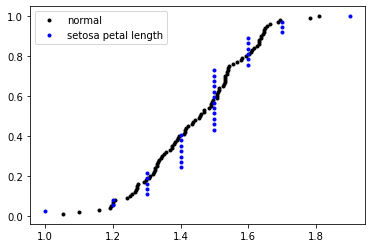

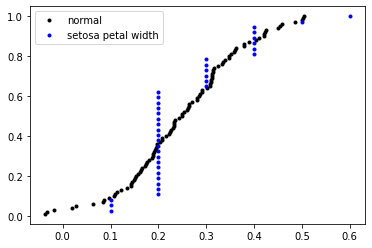

In [14]:
ecdf_plot(X_train_setosa[:, 0], color_setosa, 'setosa petal length')
ecdf_plot(X_train_setosa[:, 1], color_setosa, 'setosa petal width')

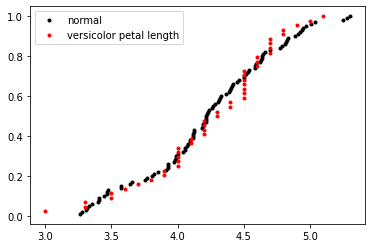

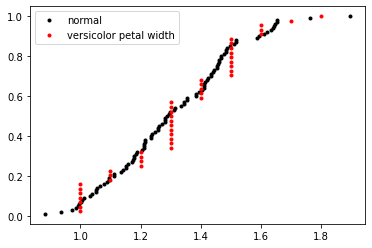

In [15]:
ecdf_plot(X_train_versicolor[:, 0], color_versicolor, 'versicolor petal length')
ecdf_plot(X_train_versicolor[:, 1], color_versicolor, 'versicolor petal width')

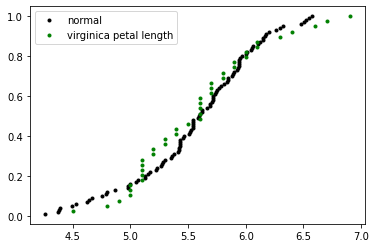

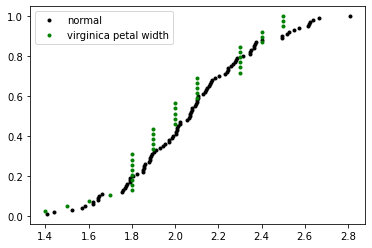

In [16]:
ecdf_plot(X_train_virginica[:, 0], color_virginica, 'virginica petal length')
ecdf_plot(X_train_virginica[:, 1], color_virginica, 'virginica petal width')

By looking at [emperical CDF](https://en.wikipedia.org/wiki/Empirical_distribution_function#:~:text=In%20statistics%2C%20an%20empirical%20distribution,of%20the%20n%20data%20points) above, although not the best, normal distribution seems like a good probability distribution to try for each category. Each category has its own mean and standard deviation. And with in each category, the records are distributed normally w.r.t. the petal length and width. Loosely, this means that close to the mean of petal length and width there are more records. Symmetrically across going away from the mean point, the rate of decrease of number of records is proportional to the distance from the mean position.

Even if we can approximate normal distribution for individual features, we still cannot not infer that the joint distribution is MVN. But, let's do some multivariate normality test on these two features and see how good of a fit MVN is.

In [17]:
print(multivariate_normality(X_train_setosa, alpha=.05))
print(multivariate_normality(X_train_versicolor, alpha=.05))
print(multivariate_normality(X_train_virginica, alpha=.05))

HZResults(hz=1.1753710379171047, pval=0.005520836229792665, normal=False)
HZResults(hz=0.4380030238479655, pval=0.5573179370556999, normal=True)
HZResults(hz=0.8731316923946509, pval=0.04085997245484832, normal=False)


Not great, but not very bad for the versicolor and virginica. Since this is mostly for educational purpose only, lets go with MVN and see where it takes us.


In [18]:
cat_setosa = NormalCategory(X_train_setosa, 2)
cat_versicolor = NormalCategory(X_train_versicolor, 2)
cat_virginica = NormalCategory(X_train_virginica, 2)

engine = InferenceEngine()

engine.add_category(cat_setosa, "setosa")
engine.add_category(cat_versicolor, "versicolor")
engine.add_category(cat_virginica, "virginica")

verifier = IrisVerifier(engine, 2)

print("Verify train data...")
verifier.verify(X_train_setosa, X_train_versicolor, X_train_virginica)
print("")

print("Verify test data...")
verifier.verify(X_test_setosa, X_test_versicolor, X_test_virginica)

print("Total correct = " , verifier.correct)
print("Total wrong = ", verifier.wrong)
print("% correct: ", round(verifier.correct*100/150, 2))

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Verify train data...
setosa marked as versicolor:  []
setosa marked as virginica:  []
versicolor marked as setosa:  []
versicolor marked as virginica:  [(4.8, 1.8)]
virginica marked as setosa:  []
virginica marked as versicolor:  [(5.0, 1.5), (4.5, 1.7)]

Verify test data...
setosa marked as versicolor:  []
setosa marked as virginica:  []
versicolor marked as setosa:  []
versicolor marked as virginica:  []
virginica marked as setosa:  []
virginica marked as versicolor:  [(5.1, 1.5)]
Total correct =  146
Total wrong =  4
% correct:  97.33


It seems performance is little better than with univariate normal distribution.

I will leave it as exercise to study each mis-classified flower due to higher probability assigned to the corresponding category at the petal length/width of the flower.